## Required libraries

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import joblib
import pickle
import snscrape.modules.twitter as sntwitter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [146]:
# making lists to append all tweets/data to
# tweets = []

In [147]:
# using sntwitter to scrape tweets and append data to lists
# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:cnnbrk').get_items()):
#     if i>5000:
#         break
#     tweets.append([tweet.content])

In [148]:
# making a dataframe from the tweets list above 
# cnn_tweets = pd.DataFrame(tweets, columns=["Tweets"])

In [149]:
# cnn_tweets.drop_duplicates()

In [150]:
# cnn_tweets.to_csv('/Users/lucashawranke/documents/data-science/sarcasm-scanner/data/cnn_tweets.csv')

In [151]:
# while on my mac
# cnn_tweets = pd.read_csv('/Users/lucashawranke/Documents/data-science/sarcasm-scanner/data/cnn_tweets.csv')
# onion_tweets = pd.read_csv('/Users/lucashawranke/Documents/data-science/sarcasm-scanner/data/onion_tweets.csv')

# while on my pc
cnn_tweets = pd.read_csv('/Users/lucas/data-science/sarcasm-scanner/data/cnn_tweets.csv')
onion_tweets = pd.read_csv('/Users/lucas/data-science/sarcasm-scanner/data/onion_tweets.csv')

In [152]:
cnn_tweets.head()

,Unnamed: 0,Tweets
0,0,Spain boosts security as prime minister target...
1,1,The House Ways and Means Committee now has six...
2,2,"Christine McVie, the singer-songwriter behind ..."
3,3,House Democrats pick Hakeem Jeffries of New Yo...
4,4,An explosion occurred at Ukraine's embassy in ...


In [158]:
# tweets2 = []

In [159]:
# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:theonion').get_items()):
#     if i>5000:
#         break
#     tweets2.append([tweet.content])

In [160]:
# onion_tweets = pd.DataFrame(tweets2, columns=["Tweets"])

In [161]:
onion_tweets.head()

,Unnamed: 0,Tweets
0,0,Biden’s Secret Service Rental Cars Burst Into ...
1,1,Exterminator Kind Of Surprised Apartment Doesn...
2,2,“Sharks can’t get cavities because their teeth...
3,3,Man Coming To Terms With Fact That Shower Not ...
4,4,https://t.co/Ks3xlHzCa1


In [162]:
# onion_tweets.to_csv('/Users/lucashawranke/documents/data-science/sarcasm-scanner/data/onion_tweets.csv')

In [180]:
tweets3 = []

In [190]:
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:clickhole').get_items()):
    if i>5000:
        break
    tweets3.append([tweet.content])

In [191]:
ch_tweets = pd.DataFrame(tweets3, columns=["Tweets"])

In [192]:
tweets4 = []

In [193]:
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:popcrave').get_items()):
    if i>5000:
        break
    tweets4.append([tweet.content])

In [194]:
pc_tweets = pd.DataFrame(tweets4, columns=["Tweets"])

In [196]:
pc_tweets.head()

,Tweets
0,https://t.co/GalVc9AWsf
1,Matty Healy reacts to allegations that he’s sh...
2,“Parlophone Records is very excited to be work...
3,"‘Love, Victor’ star Michael Cimino looks incre..."
4,Kanye West to Alex Jones in new interview:\n\n...


In [197]:
ch_tweets.head()

,Tweets
0,Fascinating. https://t.co/1rupkMSl3i
1,Groundbreaking Discovery: Paleontologists Have...
2,😘 https://t.co/cytwy3OWDJ
3,Dad’s Not Going to Like This: Mom Just Passed ...
4,Real-Life Homer Simpson? This Man Is Yellow An...


In [ ]:
train_x = cnn_tweets[:4000]
train_y = onion_tweets[:4000]

test_x = cnn_tweets[-1000:]
test_y = onion_tweets[-1000:]

In [163]:
vectorizer=CountVectorizer()
x_vectorize=vectorizer.fit_transform(cnn_tweets.Tweets).toarray() #to turn the sentences into values
x_vectorize.shape               
pca=PCA(n_components=2)
x_pca=pca.fit_transform(x_vectorize) #reducing the dimentionality to 2

cnn_tweets['x']=x_pca[:,0]
cnn_tweets['y']=x_pca[:,1]

C:\Users\lucas\AppData\Local\Temp\ipykernel_24532\3533505272.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


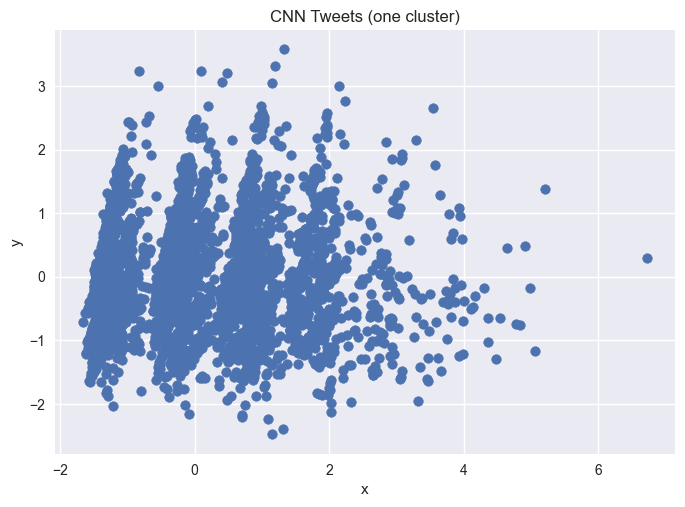

In [164]:
import matplotlib.pyplot as plt
plt.style.use('fast')
plt.title('CNN Tweets (one cluster)')
plt.xlabel("x")
plt.ylabel("y")
plt.style.use("seaborn")
plt.scatter(x_pca[:,0],x_pca[:,1]); #visualizing all clusters on same panel

In [166]:
vectorizer=CountVectorizer()

x_vectorize=vectorizer.fit_transform(onion_tweets.Tweets).toarray() #to turn the sentences into values
x_vectorize.shape               
pca=PCA(n_components=2)
x_pca=pca.fit_transform(x_vectorize) #reducing the dimentionality to 2

onion_tweets['x']=x_pca[:,0]
onion_tweets['y']=x_pca[:,1]

C:\Users\lucas\AppData\Local\Temp\ipykernel_24532\1701426157.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


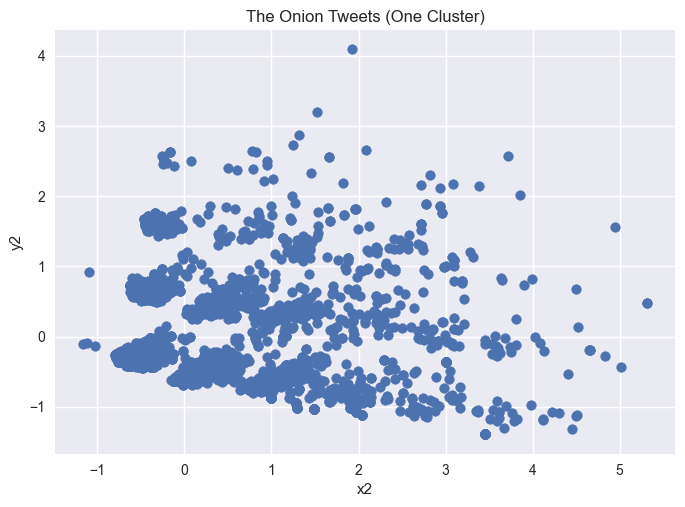

In [167]:
plt.style.use('fast')
plt.title('The Onion Tweets (One Cluster)')
plt.xlabel("x2")
plt.ylabel("y2")
plt.style.use("seaborn")
plt.scatter(x_pca[:,0],x_pca[:,1]); #visualizing all clusters on same panel

In [168]:
#mac
# real_tweets = pd.read_csv('/Users/lucashawranke/Documents/data-science/sarcasm-scanner/data/cnn_tweets.csv')
# fake_tweets = pd.read_csv('/Users/lucashawranke/Documents/data-science/sarcasm-scanner/data/onion_tweets.csv')

#pc
real_tweets = pd.read_csv('/Users/lucas/data-science/sarcasm-scanner/data/cnn_tweets.csv')
fake_tweets = pd.read_csv('/Users/lucas/data-science/sarcasm-scanner/data/onion_tweets.csv')

real_tweets['Authenticity'] = 'real'
fake_tweets['Authenticity'] = 'satire'

df = pd.concat([real_tweets, fake_tweets])

In [169]:
df

,Unnamed: 0,Tweets,Authenticity
0,0,Spain boosts security as prime minister target...,real
1,1,The House Ways and Means Committee now has six...,real
2,2,"Christine McVie, the singer-songwriter behind ...",real
3,3,House Democrats pick Hakeem Jeffries of New Yo...,real
4,4,An explosion occurred at Ukraine's embassy in ...,real
...,...,...,...
4996,4996,Woman Not So Lactose Intolerant When Boyfriend...,satire
4997,4997,Customers Relieved To See Perky 7-Eleven Cashi...,satire
4998,4998,"Complete Psychopath Meets Proper Screen Time, ...",satire
4999,4999,Everyone Still Remembers Time You Threw Up In ...,satire


In [170]:
X = df.drop('Authenticity', axis=1) 
y = df['Authenticity']

# removing NaN data

df = df.dropna()
df2 = df.copy()
df2.reset_index(inplace=True)

In [171]:
df2

,index,Unnamed: 0,Tweets,Authenticity
0,0,0,Spain boosts security as prime minister target...,real
1,1,1,The House Ways and Means Committee now has six...,real
2,2,2,"Christine McVie, the singer-songwriter behind ...",real
3,3,3,House Democrats pick Hakeem Jeffries of New Yo...,real
4,4,4,An explosion occurred at Ukraine's embassy in ...,real
...,...,...,...,...
9997,4996,4996,Woman Not So Lactose Intolerant When Boyfriend...,satire
9998,4997,4997,Customers Relieved To See Perky 7-Eleven Cashi...,satire
9999,4998,4998,"Complete Psychopath Meets Proper Screen Time, ...",satire
10000,4999,4999,Everyone Still Remembers Time You Threw Up In ...,satire


In [172]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

### Creating/Running MultinomialNB Model

In [173]:
mnb = MultinomialNB()
vectorizer = TfidfVectorizer(stop_words = 'english')

pipe = Pipeline([('vectorizer', vectorizer), ('nb', mnb)])
pipe.fit(train.Tweets, train.Authenticity)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('nb', MultinomialNB())])

In [174]:
predictions = pipe.predict(test.Tweets)
print('accuracy: ', accuracy_score(test['Authenticity'], predictions))
print('confusion matrix: ', confusion_matrix(test['Authenticity'], predictions))

accuracy:  0.927536231884058
confusion matrix:  [[1004    5]
 [ 140  852]]


### As you can see, this model has an accuracy of 92%. Although we might be able to do better, let's test it out and see what happens:

In [175]:
headline = np.array([["He Must Really Suck: This Kid Just Got Cut From The JV Basketball Team To Make A Spot For Skyler Gisondo"]])
predictions = pipe.predict(headline[0])

print(predictions)

['satire']


### True! This article is from [another](https://clickhole.com/he-must-really-suck-this-kid-just-got-cut-from-the-jv-basketball-team-to-make-a-spot-for-skyler-gisondo/) satire news site.

In [176]:
# joblib.dump(pipe, '/Users/lucashawranke/Documents/data-science/sarcasm-scanner/model.pkl') #mac
# joblib.dump(pipe, '/Users/lucas/data-science/sarcasm-scanner/model.pkl') #pc

['/Users/lucas/data-science/sarcasm-scanner/model.pkl']

In [177]:
#mac
# with open('/Users/lucashawranke/Documents/data-science/sarcasm-scanner/model.pkl', 'wb') as files:
#     pickle.dump(pipe, files)
#pc
with open('/Users/lucas/data-science/sarcasm-scanner/model.pkl', 'wb') as files:
    pickle.dump(pipe, files)

In [178]:
svc = LinearSVC()
vectorizer = TfidfVectorizer(stop_words = 'english')

pipe = Pipeline([('vectorizer', vectorizer), ('svc', svc)])
pipe.fit(train.Tweets, train.Authenticity)
predictions = pipe.predict(test.Tweets)
print('accuracy: ', accuracy_score(test['Authenticity'], predictions))
print('confusion matrix:', confusion_matrix(test['Authenticity'], predictions))

accuracy:  0.9850074962518741
confusion matrix: [[991  18]
 [ 12 980]]


### Saving LinearSVC Model

In [179]:
# joblib.dump(pipe, '/Users/lucashawranke/documents/data-science/sarcasm-scanner/model2.pkl') #mac
# joblib.dump(pipe, '/Users/lucas/data-science/sarcasm-scanner/model2.pkl') #pc